In [2]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import medfilt
import pywt
from ecgdetectors import Detectors
from scipy.signal import resample_poly

nsr_data = ['./data/nsrdb/16265',
 './data/nsrdb/16272',
 './data/nsrdb/16273',
 './data/nsrdb/16420',
 './data/nsrdb/16483',
 './data/nsrdb/16539',
 './data/nsrdb/16773',
 './data/nsrdb/16786',
 './data/nsrdb/16795',
 './data/nsrdb/17052',
 './data/nsrdb/17453',
 './data/nsrdb/18177',
 './data/nsrdb/18184',
 './data/nsrdb/19088',
 './data/nsrdb/19090',
 './data/nsrdb/19093',
 './data/nsrdb/19140',
 './data/nsrdb/19830']

In [4]:
def extract_first_30min_and_segment(record_paths):
    """
    Given a list of NSR record paths (e.g. './data/nsrdb/16265'),
    1) Read the first 30 minutes of the ECG from each record
    2) Segment that 30-min signal into six 5-min parts
    3) Return a dictionary mapping record_name -> [segment1, segment2, ... segment6]
       Each segment is a NumPy array of shape (num_samples_5min, num_channels).
    """
    
    # For 30 min, we have 30 * 60 = 1800 seconds. 
    # For 5 min, we have 5 * 60 = 300 seconds.
    
    first_30min_segments = {}
    
    for record_path in record_paths:
        
        # Extract record name from path
        # e.g. record_path = "./data/nsrdb/16265" => record_name = "16265"
        record_dir, record_name = os.path.split(record_path)
      
        print(f"Processing {record_name} ...")
        
        # We want the first 30 minutes => 1800 seconds => num_samples = 1800 * fs
        fs = 128
        num_samples_30min = int(60 * 60 * fs)
        
        # Read from sample 0 to sample 0+num_samples_30min
        try:
            rec = wfdb.rdrecord(record_path, sampfrom=0, sampto=num_samples_30min)
        except Exception as e:
            print(f"[ERROR] Could not read {record_path}: {e}")
            continue
        
        if rec.p_signal is None:
            print(f"[WARN] No signal found in {record_name}. Skipping.")
            continue
        
        full_30min = rec.p_signal[:,0]
        
        # Segment the 30-min array into six 5-min parts
        # Each 5-min part = 5 * 60 * fs samples
        
        samples_5min = int(10 * 60 * fs)  # 300 seconds * 128 => 38400
        
        # We can slice in 6 equal blocks
        segments_5min = []
        for i in range(6):
            start_i = i * samples_5min
            end_i = start_i + samples_5min
            segment = full_30min[start_i:end_i]
            segments_5min.append(segment)
        
        # Store in a dictionary
        first_30min_segments[record_name] = segments_5min
        print(f"[OK] Extracted 6 segments of 5 min each from {record_name}.")
    
    return first_30min_segments

In [5]:
nsr_30min_segments_5min_each_6pc = extract_first_30min_and_segment(nsr_data)

Processing 16265 ...
[OK] Extracted 6 segments of 5 min each from 16265.
Processing 16272 ...
[OK] Extracted 6 segments of 5 min each from 16272.
Processing 16273 ...
[OK] Extracted 6 segments of 5 min each from 16273.
Processing 16420 ...
[OK] Extracted 6 segments of 5 min each from 16420.
Processing 16483 ...
[OK] Extracted 6 segments of 5 min each from 16483.
Processing 16539 ...
[OK] Extracted 6 segments of 5 min each from 16539.
Processing 16773 ...
[OK] Extracted 6 segments of 5 min each from 16773.
Processing 16786 ...
[OK] Extracted 6 segments of 5 min each from 16786.
Processing 16795 ...
[OK] Extracted 6 segments of 5 min each from 16795.
Processing 17052 ...
[OK] Extracted 6 segments of 5 min each from 17052.
Processing 17453 ...
[OK] Extracted 6 segments of 5 min each from 17453.
Processing 18177 ...
[OK] Extracted 6 segments of 5 min each from 18177.
Processing 18184 ...
[OK] Extracted 6 segments of 5 min each from 18184.
Processing 19088 ...
[OK] Extracted 6 segments of 5

In [6]:
nsr_30min_segments_5min_each_6pc

{'16265': [array([-0.165, -0.155, -0.195, ..., -0.365,  1.475,  2.795]),
  array([ 2.935,  2.535,  0.605, ..., -0.145, -0.145, -0.135]),
  array([-0.175, -0.135, -0.175, ..., -0.135, -0.175, -0.175]),
  array([-0.155, -0.115, -0.155, ..., -0.765, -0.855, -0.005]),
  array([ 1.865,  2.825,  2.685, ..., -0.185, -0.205, -0.185]),
  array([-0.165, -0.185, -0.165, ..., -0.105, -0.135, -0.065])],
 '16272': [array([-0.185, -0.215, -0.215, ..., -0.085, -0.075, -0.055]),
  array([-0.085, -0.085, -0.095, ..., -0.075, -0.065, -0.065]),
  array([-0.075, -0.075, -0.085, ..., -0.045, -0.045, -0.055]),
  array([-0.035, -0.045, -0.085, ..., -0.105, -0.105, -0.095]),
  array([-0.105, -0.095, -0.115, ..., -0.095, -0.055, -0.065]),
  array([-0.095, -0.065, -0.105, ..., -0.105, -0.105, -0.095])],
 '16273': [array([-0.305, -0.265, -0.245, ...,  1.485,  2.755,  3.225]),
  array([ 1.925,  0.335, -0.205, ..., -0.165, -0.175, -0.175]),
  array([-0.185, -0.185, -0.185, ...,  0.485,  0.395,  0.365]),
  array([ 0

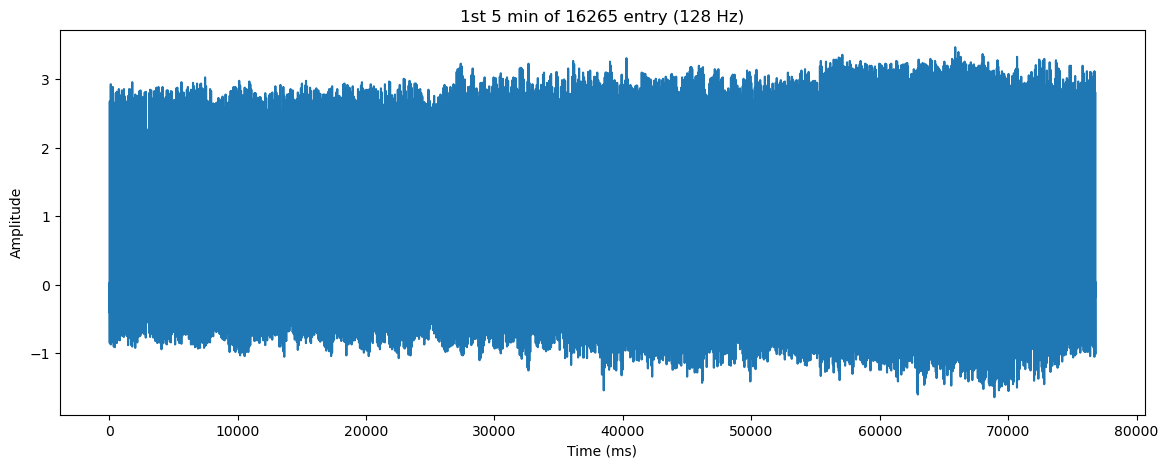

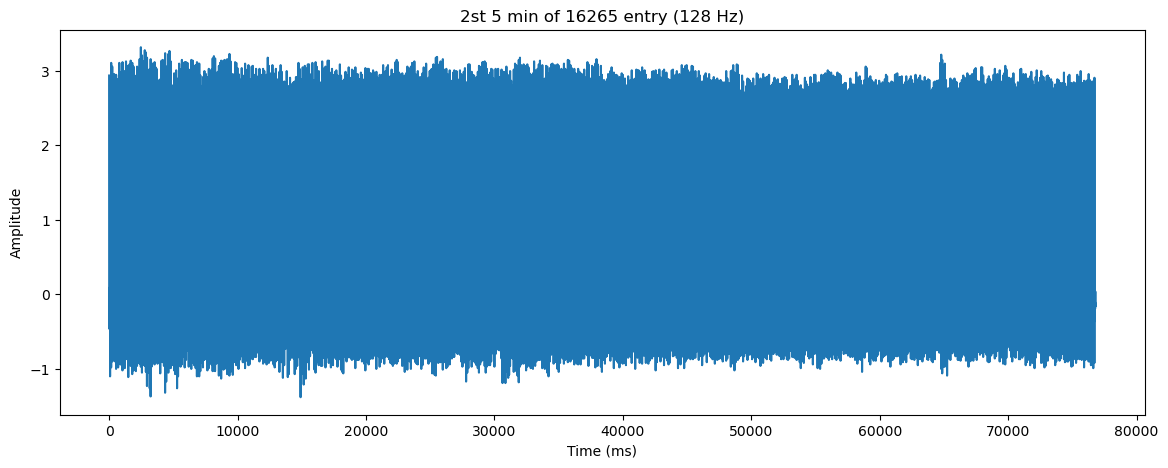

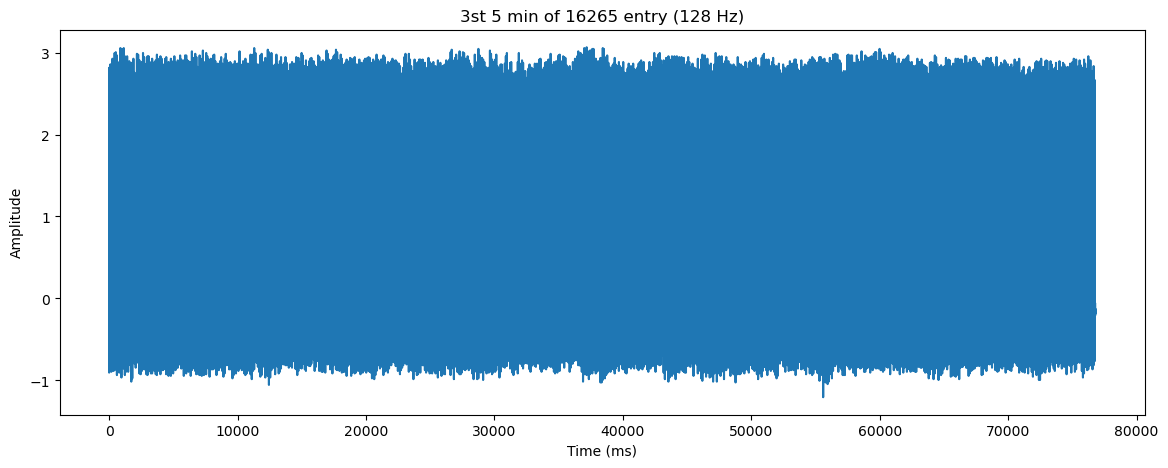

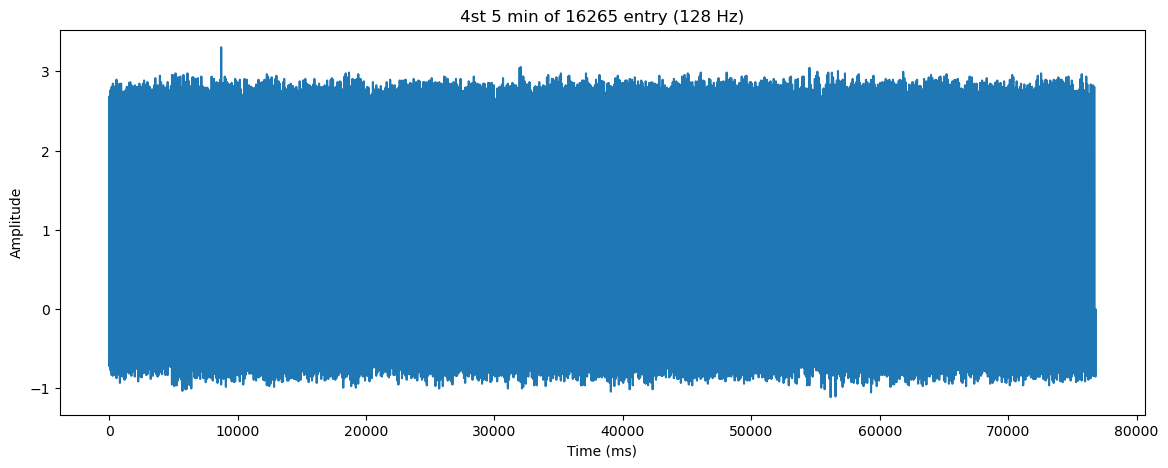

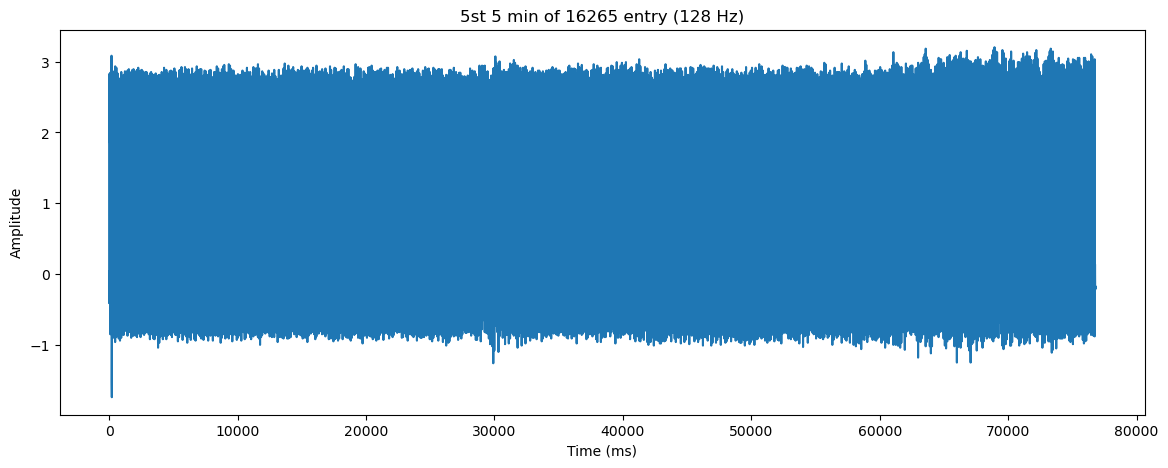

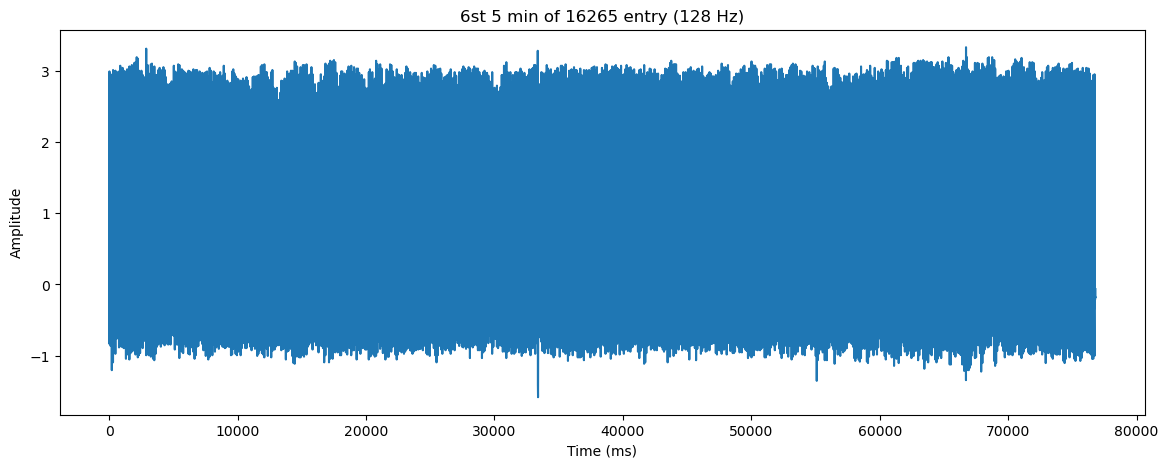

In [7]:
for i in range(6):
    five_min_OF_16265 = nsr_30min_segments_5min_each_6pc['16265'][i]
    plt.figure(figsize=(14, 5))
    plt.subplot()
    plt.plot(five_min_OF_16265)
    plt.title(f'{i+1}st 5 min of 16265 entry (128 Hz)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    
    plt.show()

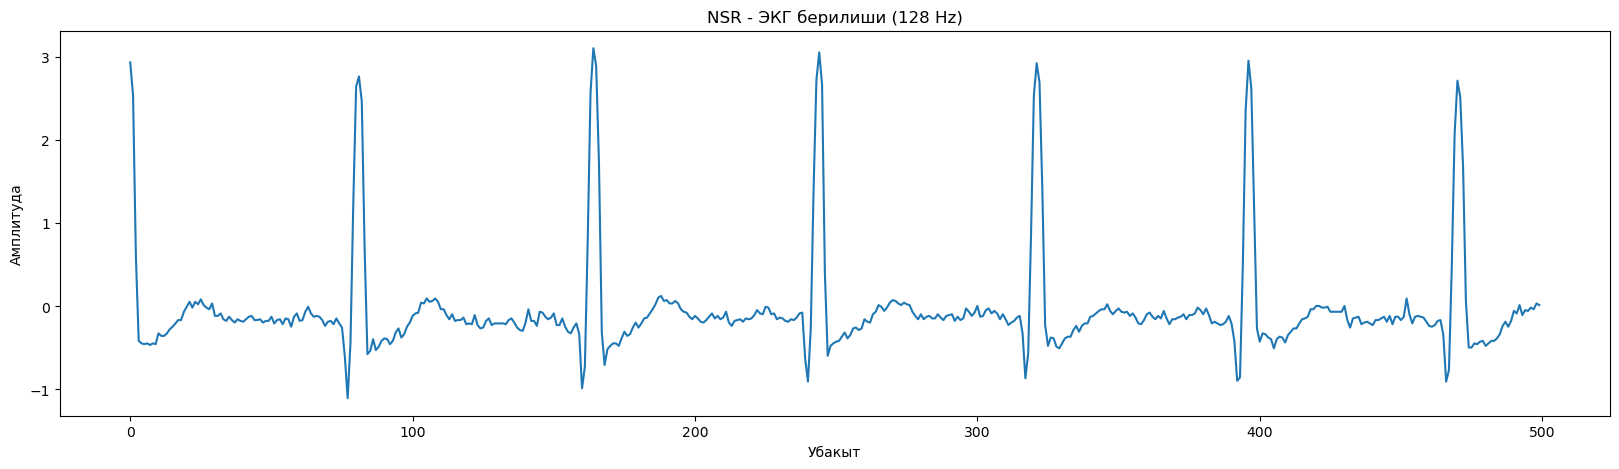

In [14]:
five_min_OF_16265 = nsr_30min_segments_5min_each_6pc['16265'][1]
plt.figure(figsize=(20, 5))
plt.subplot()
plt.plot(five_min_OF_16265[:500])
plt.title(f'NSR - ЭКГ берилиши (128 Hz)')
plt.xlabel('Убакыт')
plt.ylabel('Амплитуда')
plt.savefig('./img/nsr500.png', dpi=300, bbox_inches='tight')
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 's'

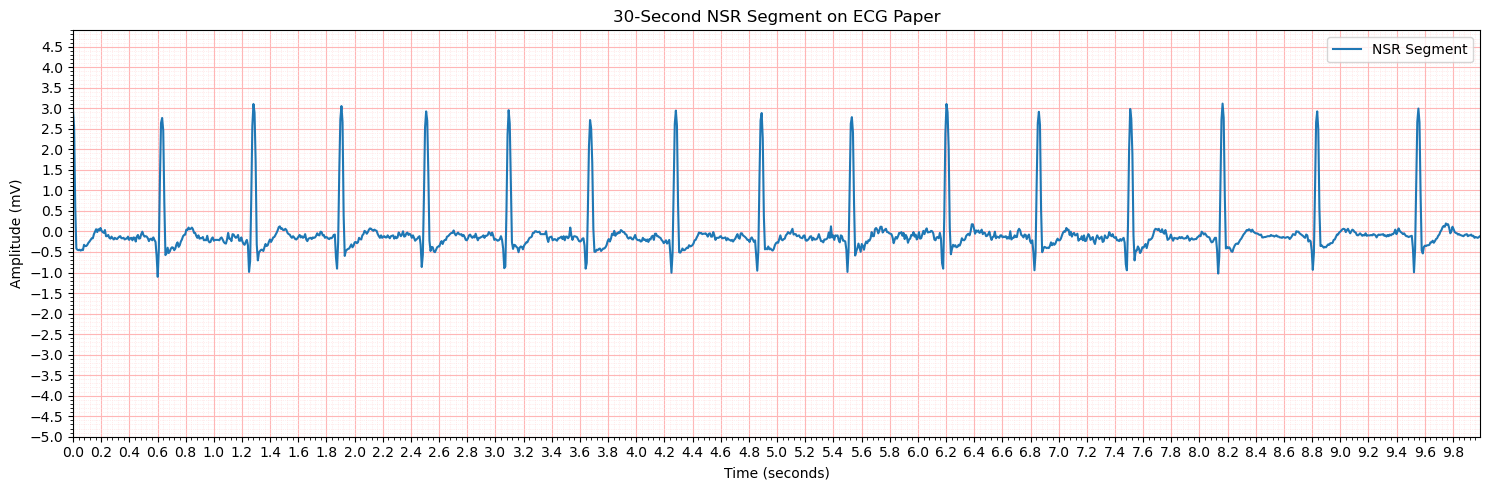

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
fs_nsr = 128  # NSR sampling frequency
duration_sec = 10  # Duration to plot
samples_to_plot = duration_sec * fs_nsr

# Get the first 30 seconds of NSR data
ecg_nsr_30s = five_min_OF_16265[:samples_to_plot]
time_nsr = np.arange(len(ecg_nsr_30s)) / fs_nsr  # Time axis in seconds

# Plot
plt.figure(figsize=(15, 5))
ax = plt.gca()

# ECG signal
ax.plot(time_nsr, ecg_nsr_30s, label='NSR Segment')

# Axis limits
ax.set_xlim(time_nsr[0], time_nsr[-1])
ax.set_ylim(min(ecg_nsr_30s) - 0.5, max(ecg_nsr_30s) + 0.5)

# ECG paper grid colors
soft_red_major = '#FFB6B6'
soft_red_minor = '#FFDCDC'

# ECG grid settings
# Minor: every 0.04 s and 0.1 mV
ax.set_xticks(np.arange(time_nsr[0], time_nsr[-1], 0.04), minor=True)
ax.set_yticks(np.arange(-5, 5, 0.1), minor=True)

# Major: every 0.2 s and 0.5 mV
ax.set_xticks(np.arange(time_nsr[0], time_nsr[-1], 0.2))
ax.set_yticks(np.arange(-5, 5, 0.5))

ax.grid(which='major', color=soft_red_major, linewidth=0.8)
ax.grid(which='minor', color=soft_red_minor, linestyle=':', linewidth=0.5)

# Labels
ax.set_title('30-Second NSR Segment on ECG Paper')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude (mV)')
ax.legend()

plt.tight_layout()
plt.s


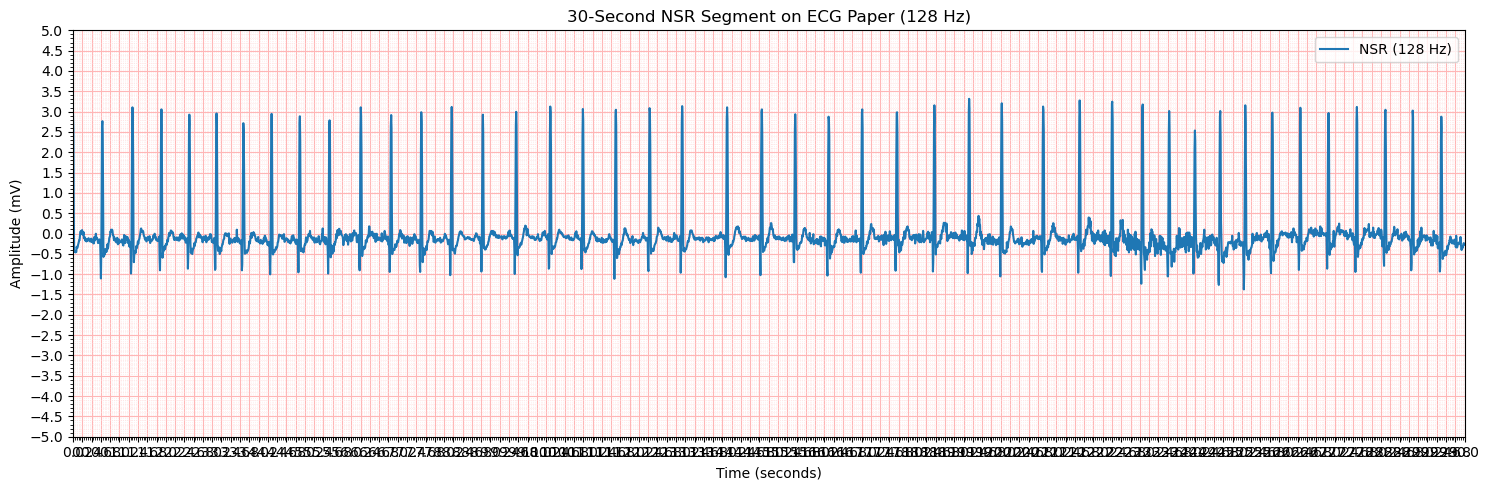

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling frequency
fs_nsr = 128  # Hz

# Select first 30 seconds of the signal
samples_to_plot = 30 * fs_nsr
ecg_nsr_30s = five_min_OF_16265[:samples_to_plot]
time_nsr = np.arange(samples_to_plot) / fs_nsr  # Time in seconds

# Plot setup
plt.figure(figsize=(15, 5))
ax = plt.gca()

# Plot ECG
ax.plot(time_nsr, ecg_nsr_30s, label='NSR (128 Hz)')

# Axis range
ax.set_xlim(0, 30)
ax.set_ylim(min(ecg_nsr_30s) - 0.5, max(ecg_nsr_30s) + 0.5)

# ECG paper colors (light)
soft_red_major = '#FFB6B6'
soft_red_minor = '#FFDCDC'

# Minor grid: every 0.04 s (small square), 0.1 mV
ax.set_xticks(np.arange(0, 30, 0.04), minor=True)
ax.set_yticks(np.arange(-5, 5, 0.1), minor=True)

# Major grid: every 0.2 s (big square), 0.5 mV
ax.set_xticks(np.arange(0, 30.1, 0.2))
ax.set_yticks(np.arange(-5, 5.1, 0.5))

ax.grid(which='major', color=soft_red_major, linewidth=0.8)
ax.grid(which='minor', color=soft_red_minor, linestyle=':', linewidth=0.5)

# Labels
ax.set_title('30-Second NSR Segment on ECG Paper (128 Hz)')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude (mV)')
ax.legend()

plt.tight_layout()
plt.show()
